Это задача бинарной классификации (получил ли сотрудник повышение или нет).

In [161]:
!pip install xgboost phik streamlit

In [162]:
# импорты библиотек

import pickle
import streamlit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import imblearn
import phik
import gradio as gr
import pickle
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    #plot_confusion_matrix,
)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
pd.set_option("display.max_columns", None)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
pd.set_option("display.float_format", lambda x: "%.3f" % x)
import warnings
warnings.filterwarnings("ignore")

# установка размера  и стиля для графиков
plt.rcParams['figure.figsize'] = (16, 5)
plt.style.use('fivethirtyeight')

In [163]:
# загрузка датасета

df = pd.read_csv('/content/dataset.csv')
df.sample(7)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
23806,6029,Sales & Marketing,region_23,Bachelor's,m,other,1,39,1.000,6,0,0,49,0
786,60503,Sales & Marketing,region_29,Bachelor's,m,other,1,30,NaN,1,1,0,47,0
28771,14676,Operations,region_25,Bachelor's,m,other,1,28,NaN,1,1,0,60,0
10204,48165,Procurement,region_2,Master's & above,f,sourcing,1,32,4.000,7,0,0,93,1
13847,42771,Finance,region_28,Bachelor's,m,other,1,29,4.000,5,0,0,57,0
54117,33786,Technology,region_4,Bachelor's,m,sourcing,3,31,3.000,5,0,0,86,0
48840,25641,Technology,region_2,Bachelor's,m,other,1,40,3.000,5,1,0,82,0


In [164]:
# размерность
print("Shape of the Training Data :", df.shape)

Shape of the Training Data : (54808, 14)


Всего в датасете 14 столбцов и 54808 строк.

In [165]:
# столбцы
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

Наименования столбцов:

	•	employee_id  
	•	department   
	•	region
	•	education
	•	gender
	•	recruitment_channel
	•	nooftrainings
	•	age
	•	previousyearrating
	•	lengthofservice
	•	KPIs_met >80%
	•	awards_won?
	•	avgtrainingscore
	•	is_promoted

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


## EDA

In [167]:
# % отсутствующих данных в признаках
round(df.isnull().sum() / df.isnull().count() * 100, 1)

employee_id            0.000
department             0.000
region                 0.000
education              4.400
gender                 0.000
recruitment_channel    0.000
no_of_trainings        0.000
age                    0.000
previous_year_rating   7.500
length_of_service      0.000
KPIs_met >80%          0.000
awards_won?            0.000
avg_training_score     0.000
is_promoted            0.000
dtype: float64

Пропуски в данных есть в столбцах education ,previous_year_rating

In [168]:
imputer_mode = SimpleImputer(strategy="most_frequent")
imputer_median = SimpleImputer(strategy="median")

In [169]:
df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [170]:
df.duplicated().sum()

0

Нет дубликатов строк.

In [171]:
# количество уникальных значений
df.nunique()

employee_id             54808
department                  9
region                     34
education                   3
gender                      2
recruitment_channel         3
no_of_trainings            10
age                        41
previous_year_rating        5
length_of_service          35
KPIs_met >80%               2
awards_won?                 2
avg_training_score         61
is_promoted                 2
dtype: int64

In [172]:
df['department'].value_counts()

department
Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: count, dtype: int64

Больше всего сотрудников в отделе "Sales & Marketing", меньше всего в R&D.

In [173]:
df['region'].value_counts()

region
region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: count, dtype: int64

Больше всего сотрудников из 2 региона (области), меньше всего из 18-ого.

In [174]:
df.set_index('employee_id', inplace=True)

In [175]:
# описательная статистика для некатегориальных признаков
df.describe().style.background_gradient(cmap = 'viridis')

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [176]:
# аналогично и для категориальных признаков
df.describe(include = 'object')

,department,region,education,gender,recruitment_channel
count,54808,54808,52399,54808,54808
unique,9,34,3,2,3
top,Sales & Marketing,region_2,Bachelor's,m,other
freq,16840,12343,36669,38496,30446


*Профиль большинства сотрудников: мужчина из 2 региона, имеющий высшее образование и работающий в отделе, занимающемся продажами и маркетингом.*

Просмотр уникальных значений

In [177]:
for i in df.describe(include=["object"]).columns:
    print("Unique values in", i, "are:")
    print(round(df[i].value_counts() / df[i].value_counts().sum() * 100), 2)
    print("*" * 60)

Unique values in department are:
department
Sales & Marketing   31.000
Operations          21.000
Technology          13.000
Procurement         13.000
Analytics           10.000
Finance              5.000
HR                   4.000
Legal                2.000
R&D                  2.000
Name: count, dtype: float64 2
************************************************************
Unique values in region are:
region
region_2    23.000
region_22   12.000
region_7     9.000
region_15    5.000
region_13    5.000
region_26    4.000
region_31    4.000
region_4     3.000
region_27    3.000
region_16    3.000
region_28    2.000
region_11    2.000
region_23    2.000
region_29    2.000
region_32    2.000
region_19    2.000
region_20    2.000
region_14    2.000
region_25    1.000
region_17    1.000
region_5     1.000
region_6     1.000
region_30    1.000
region_8     1.000
region_10    1.000
region_1     1.000
region_24    1.000
region_12    1.000
region_9     1.000
region_21    1.000
region_3     1.0

In [178]:
df['is_promoted'].value_counts()

is_promoted
0    50140
1     4668
Name: count, dtype: int64

Сильный дисбаланс классов, почти в 10 раз.

In [179]:
# функция для гистограмм и боксплота
sns.set(style="darkgrid")

def histogram_boxplot(df, feature, figsize=(12, 6), kde=False, bins=15):

    f, (ax_box, ax_histo) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (0.20, 0.80)}, figsize=figsize
    )

    sns.boxplot(data=df, x=feature, ax=ax_box, showmeans=True, color="violet")
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_histo, bins=bins, palette="winter"
    ) if bins else sns.histplot(data=df, x=feature, kde=kde, ax=ax_histo)


    ax_histo.axvline(df[feature].mean(), color="black", linestyle="--")
    ax_histo.axvline(df[feature].median(), color="violet", linestyle="-")
    plt.show()

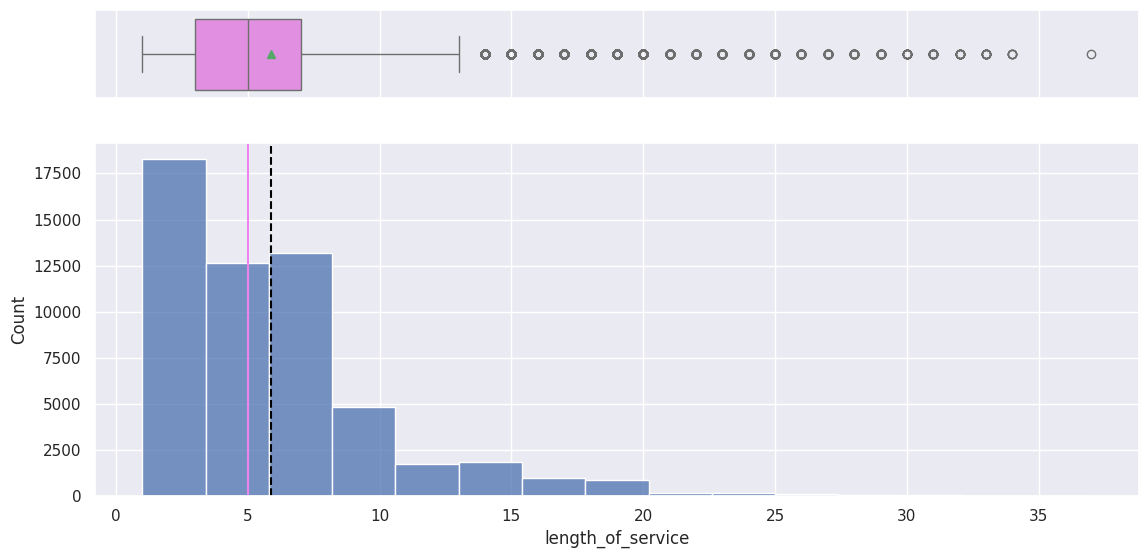

In [180]:
histogram_boxplot(df, "length_of_service")

Видны выбросы

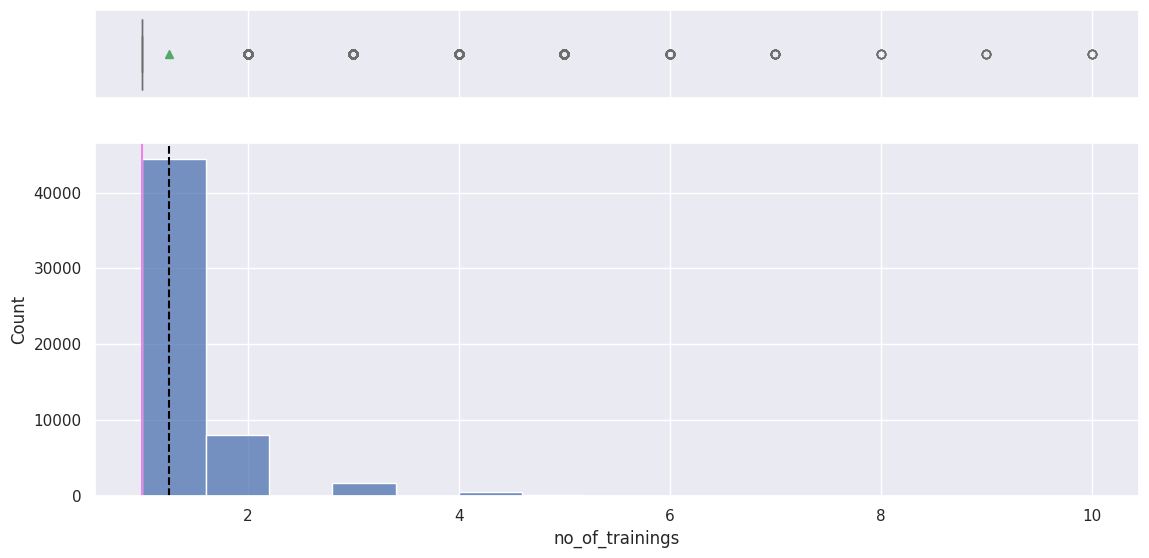

In [181]:
histogram_boxplot(df, "no_of_trainings")

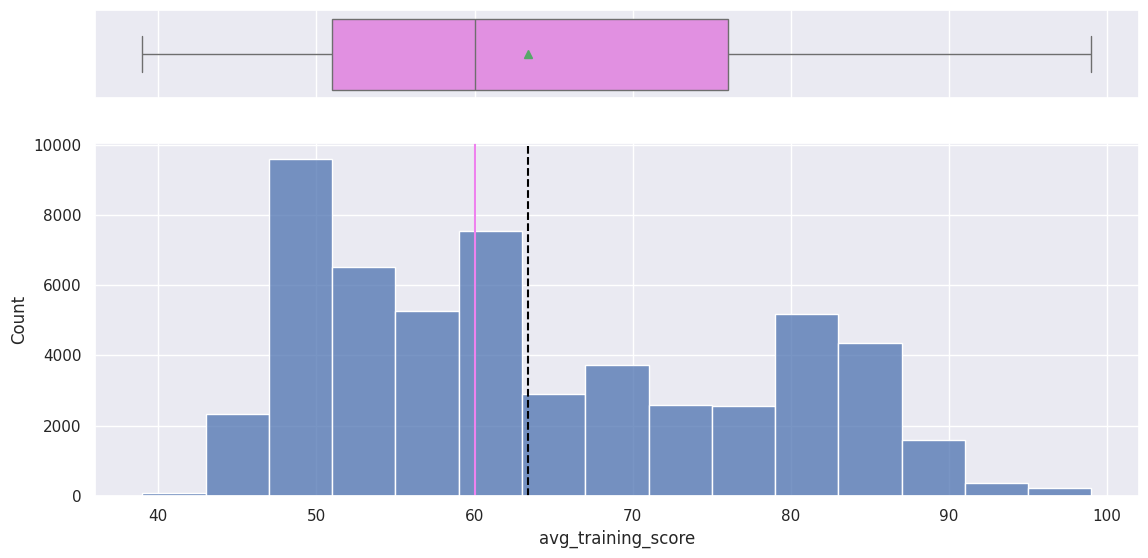

In [182]:
histogram_boxplot(df, "avg_training_score")

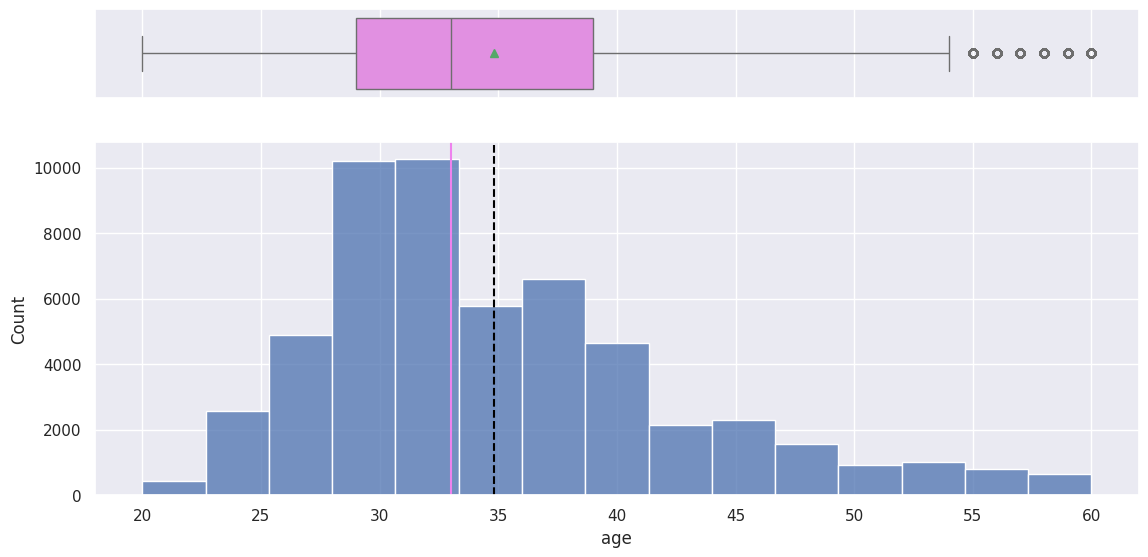

In [183]:
histogram_boxplot(df, "age")

In [184]:
def labeled_barplot(data, feature, perc=False, n=None):

    total = len(df[feature])
    count = df[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=df,
        x=feature,
        palette="viridis",
        order=df[feature].value_counts().index[:n].sort_values(),
    )

    plt.show()

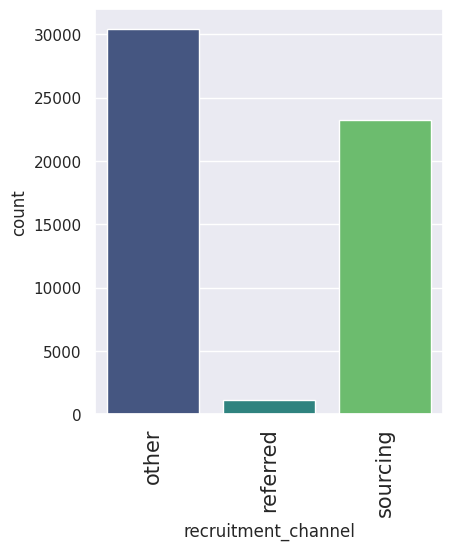

In [185]:
labeled_barplot(df, "recruitment_channel")

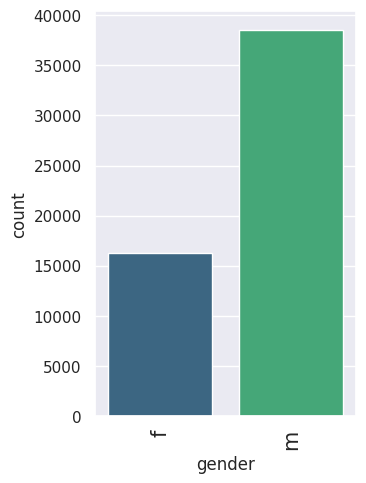

In [186]:
labeled_barplot(df, "gender")

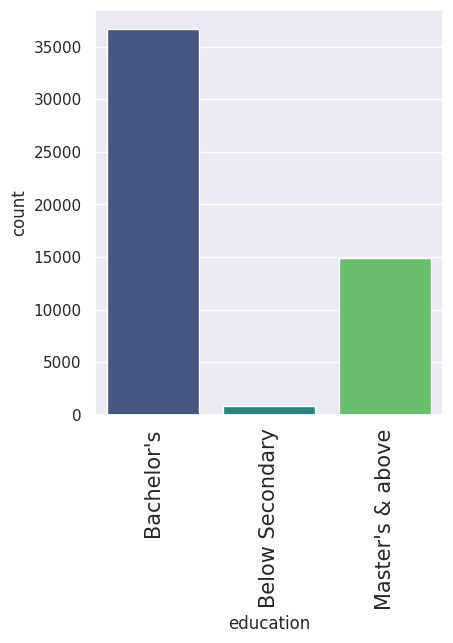

In [187]:
labeled_barplot(df, "education")

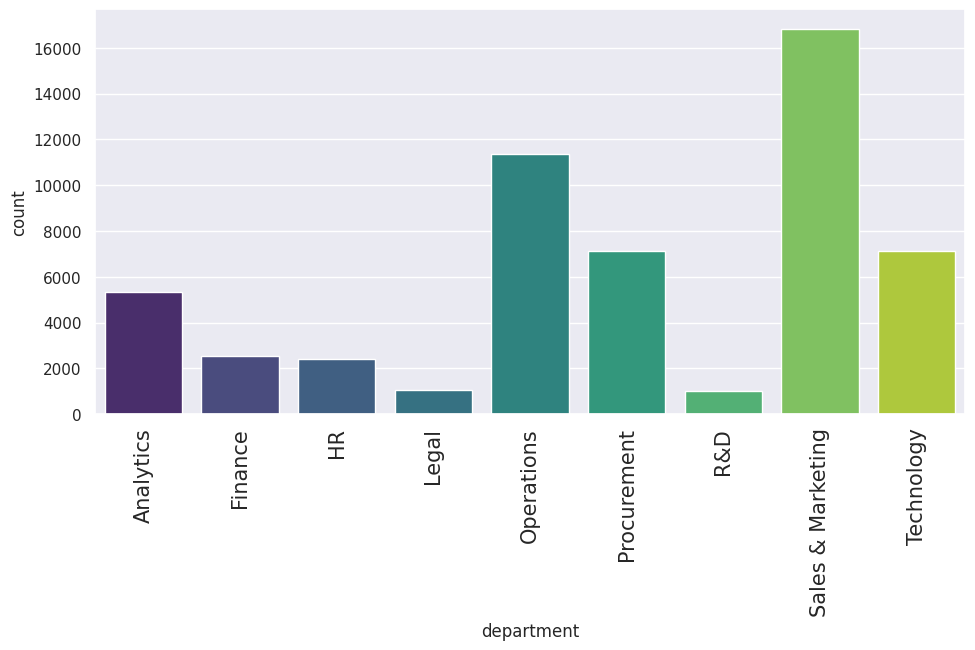

In [188]:
labeled_barplot(df, "department")

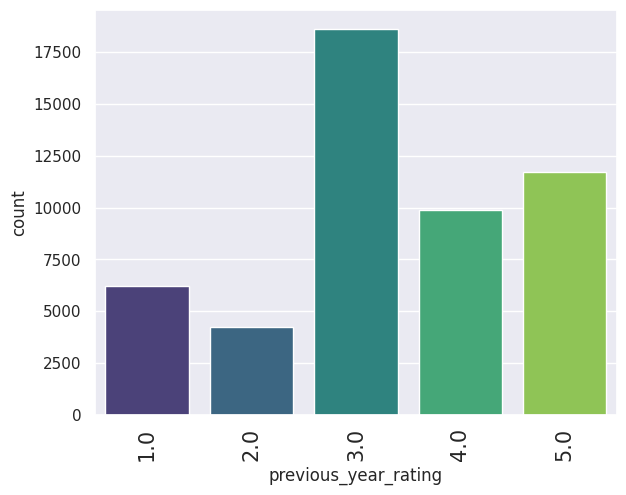

In [189]:
labeled_barplot(df, "previous_year_rating")

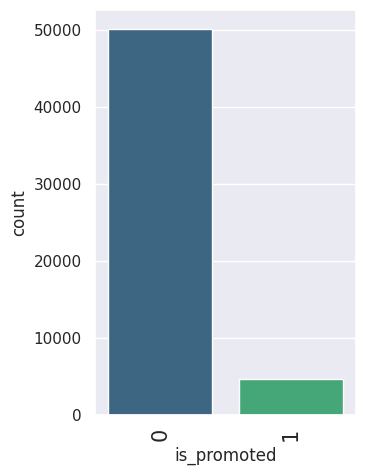

In [190]:
labeled_barplot(df, "is_promoted")

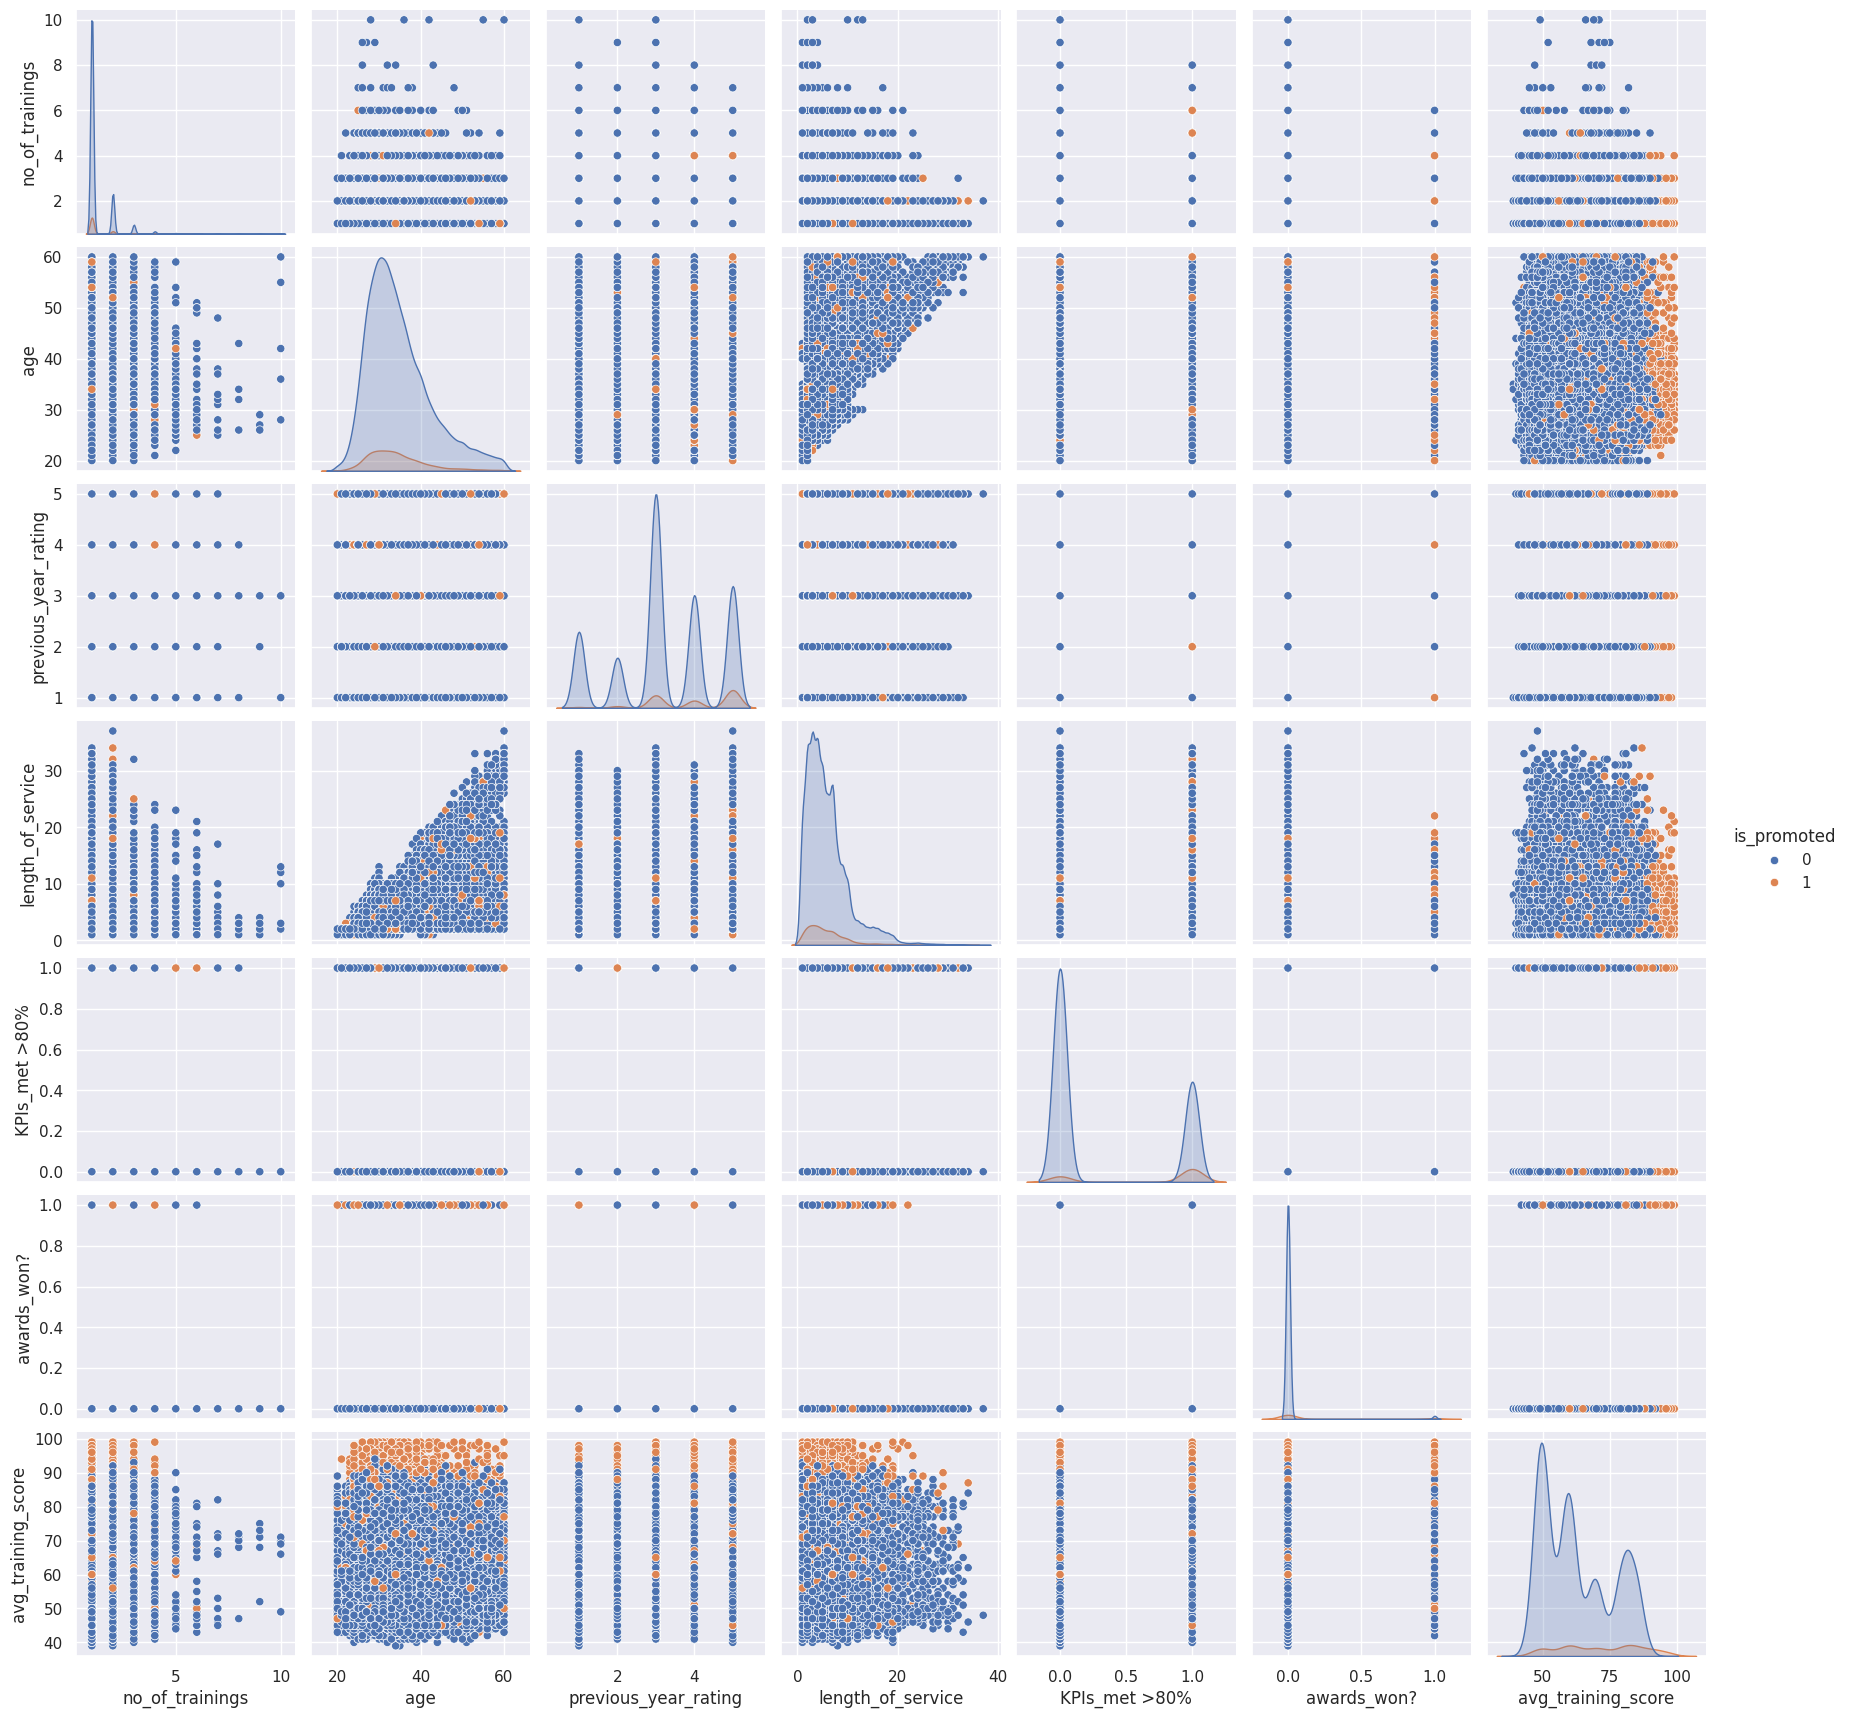

In [191]:
sns.pairplot(df, hue="is_promoted")

In [192]:
## функция для визуализации распределений
def distribution_target(data, predictor, target):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    target_uniq = data[target].unique()
    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="blue",
    )
    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="violet",
    )
    axs[1, 0].set_title("Boxplot with the target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")
    axs[1, 1].set_title("Boxplot (without outliers) with the target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )
    plt.tight_layout()
    plt.show()

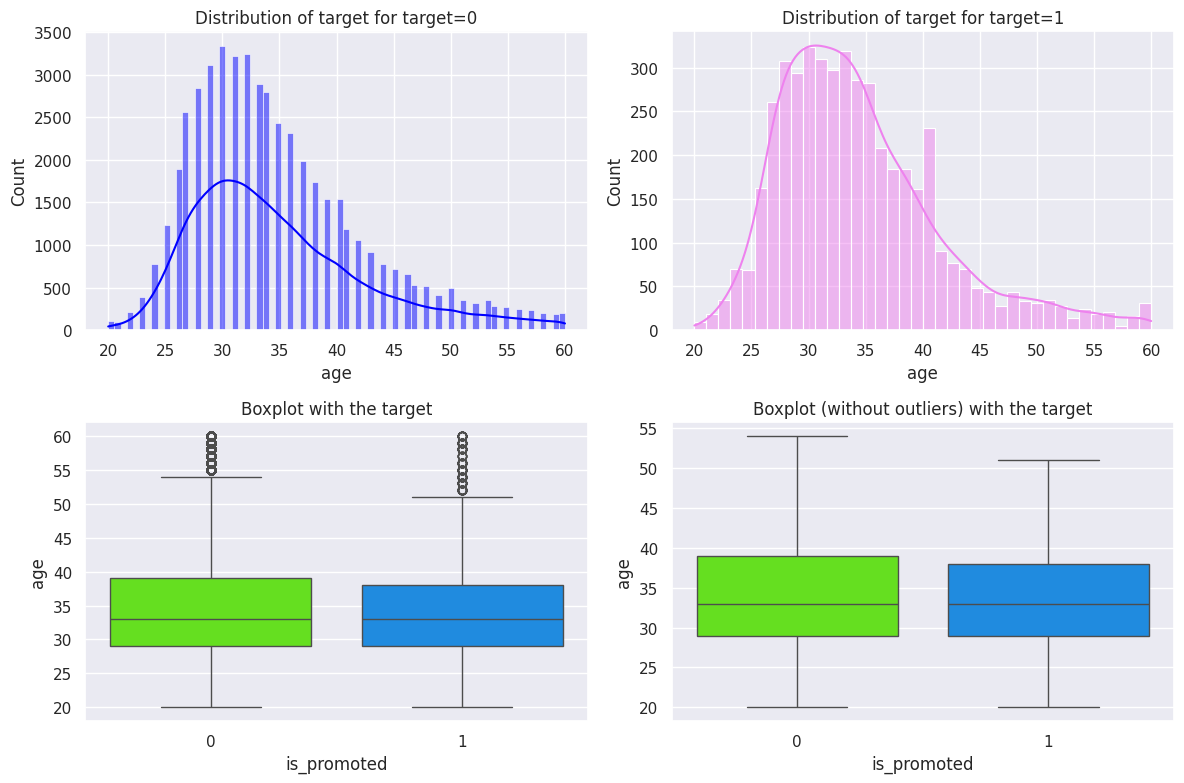

In [193]:
distribution_target(df, "age", "is_promoted")

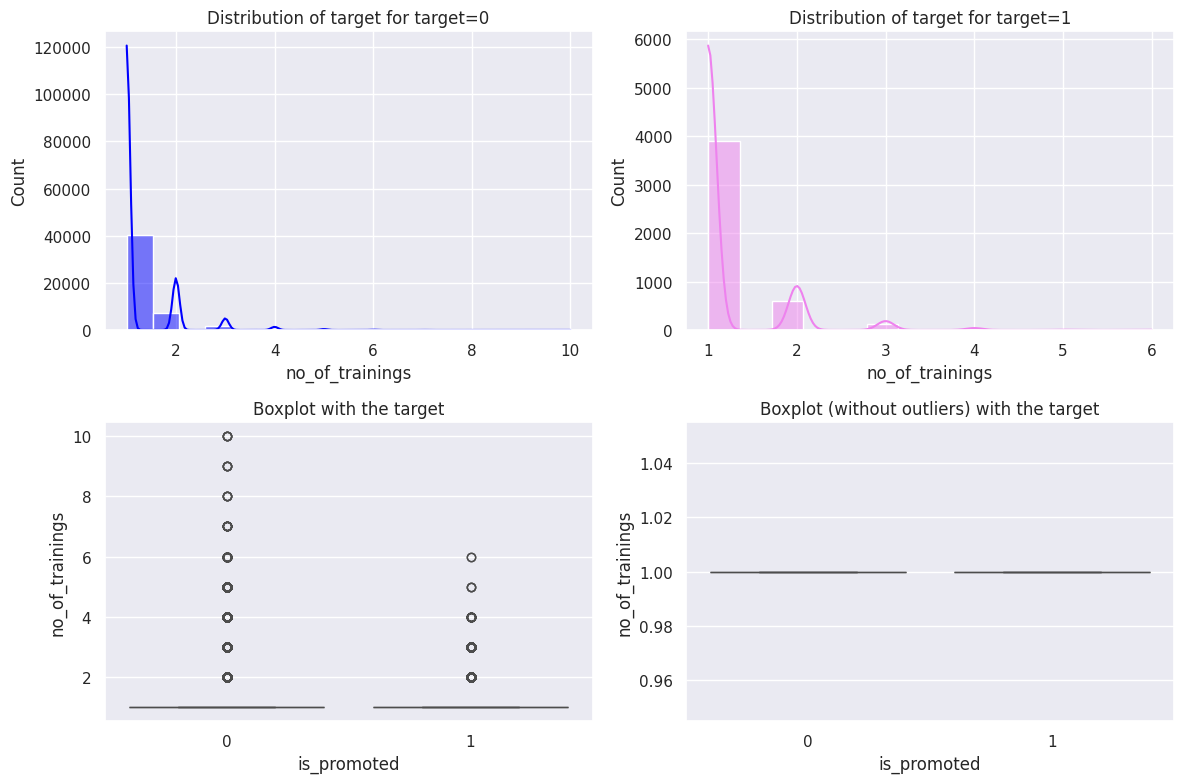

In [194]:
distribution_target(df, "no_of_trainings", "is_promoted")

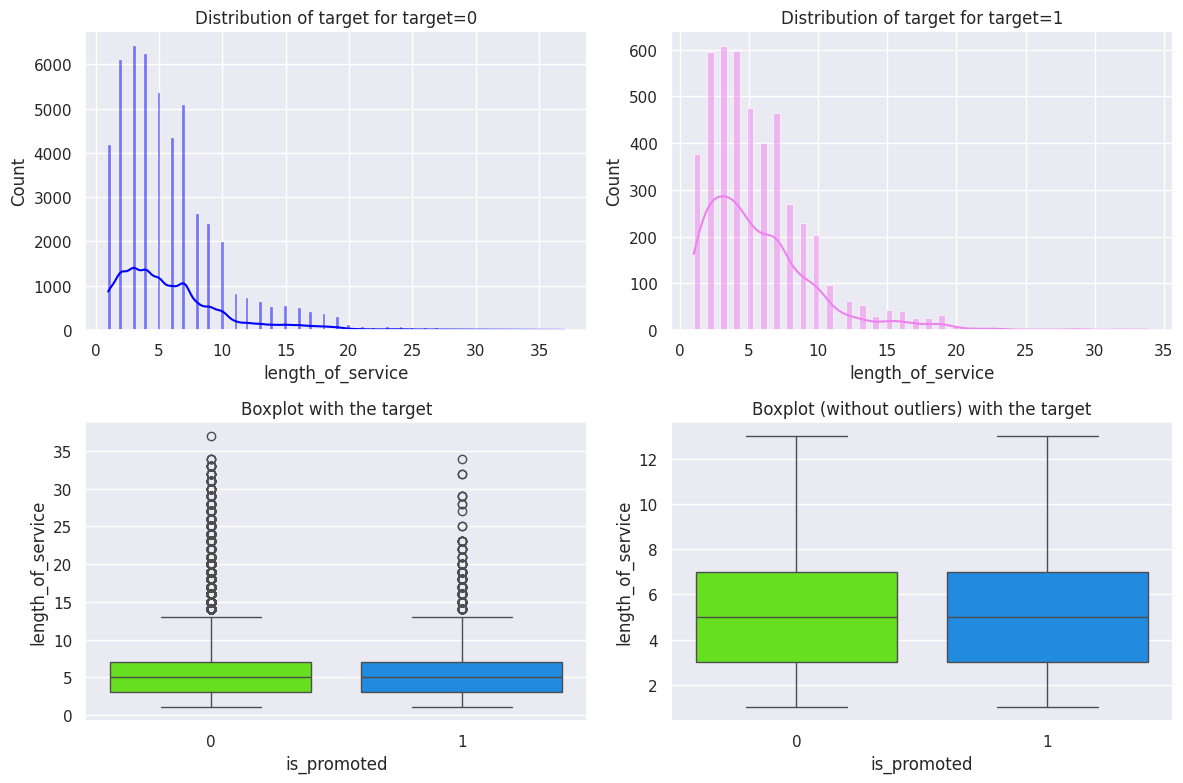

In [195]:
distribution_target(df, "length_of_service", "is_promoted")

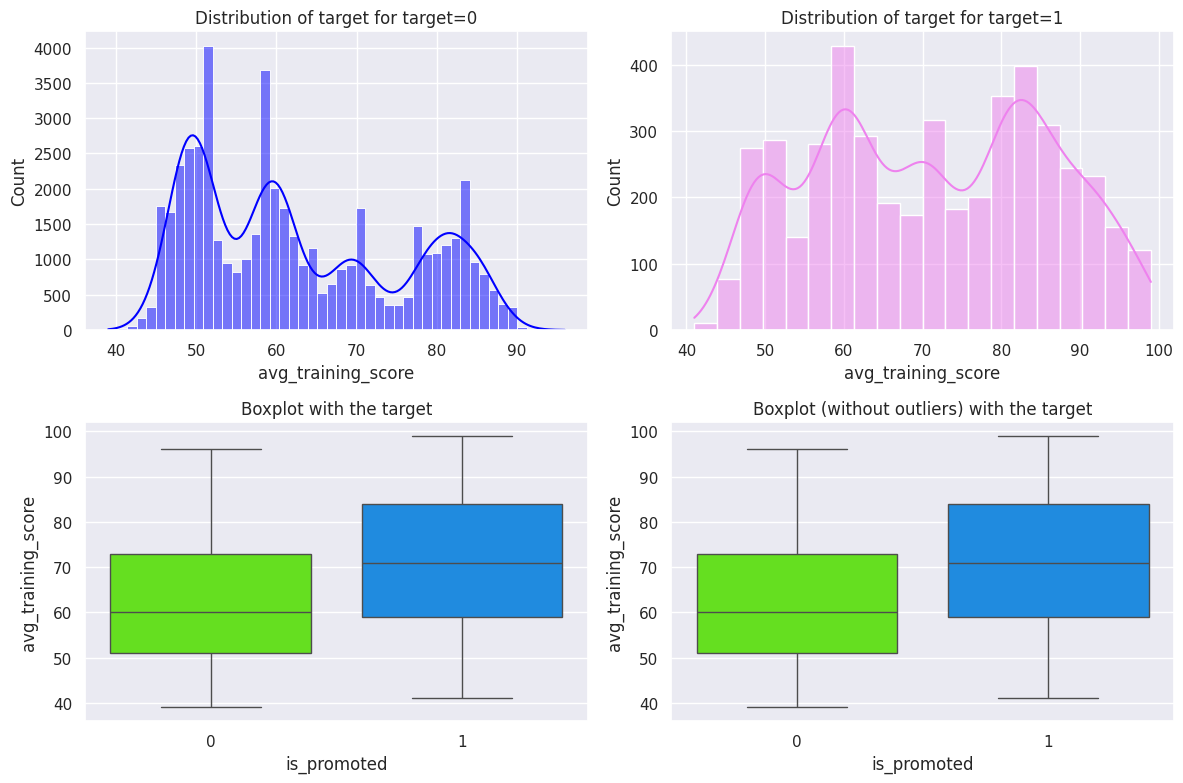

In [196]:
distribution_target(df, "avg_training_score", "is_promoted")

In [197]:
# моя функция для объед.барплотов
def stacked_barplot(data, predictor, target):
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]

    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

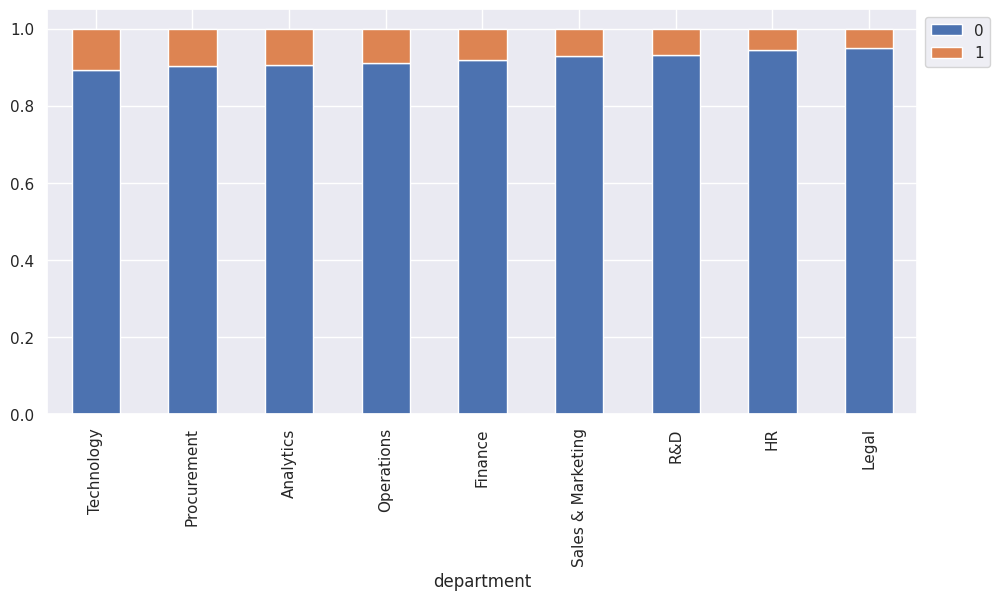

In [198]:
stacked_barplot(df, "department", "is_promoted")

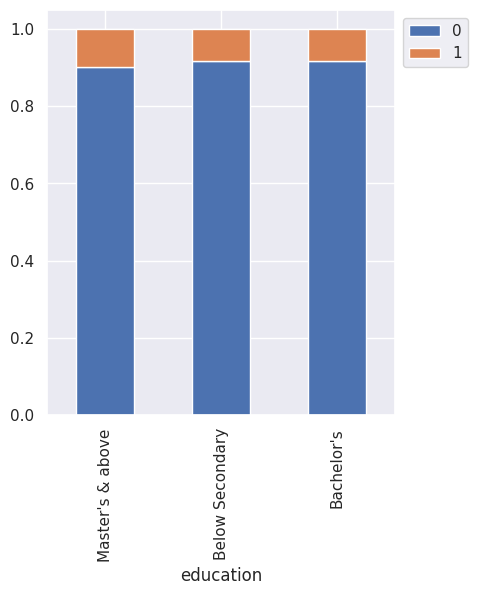

In [199]:
stacked_barplot(df, "education", "is_promoted")

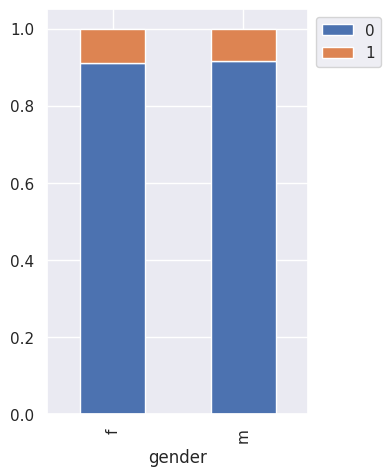

In [200]:
stacked_barplot(df, "gender", "is_promoted")

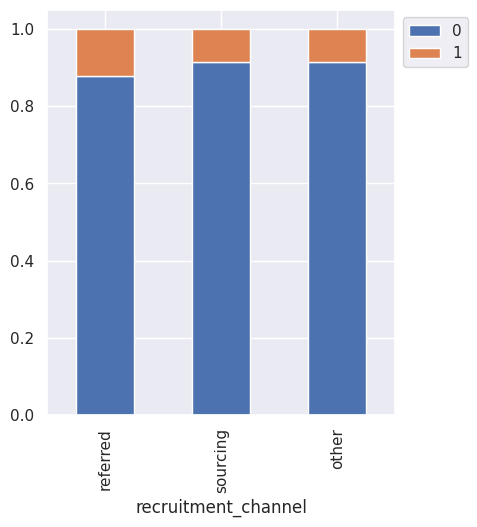

In [201]:
stacked_barplot(df, "recruitment_channel", "is_promoted")

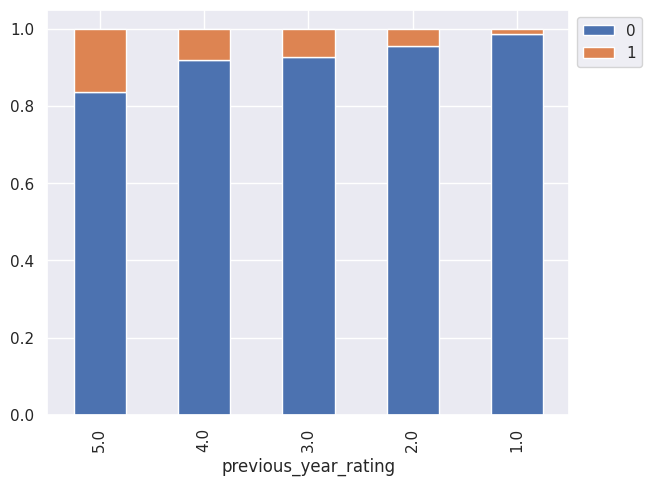

In [202]:
stacked_barplot(df, "previous_year_rating", "is_promoted")

### Импутация NaN

In [203]:
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['previous_year_rating'] = df['previous_year_rating'].fillna(df['previous_year_rating'].mode()[0])

print("Количество пропущенных значений :", df.isnull().sum().sum())

Количество пропущенных значений : 0


## Выбросы


In [204]:
df.select_dtypes('number').head()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
employee_id,,,,,,,,
65438,1,35,5.000,8,1,0,49,0
65141,1,30,5.000,4,0,0,60,0
7513,1,34,3.000,7,0,0,50,0
2542,2,39,1.000,10,0,0,50,0
48945,1,45,3.000,2,0,0,73,0


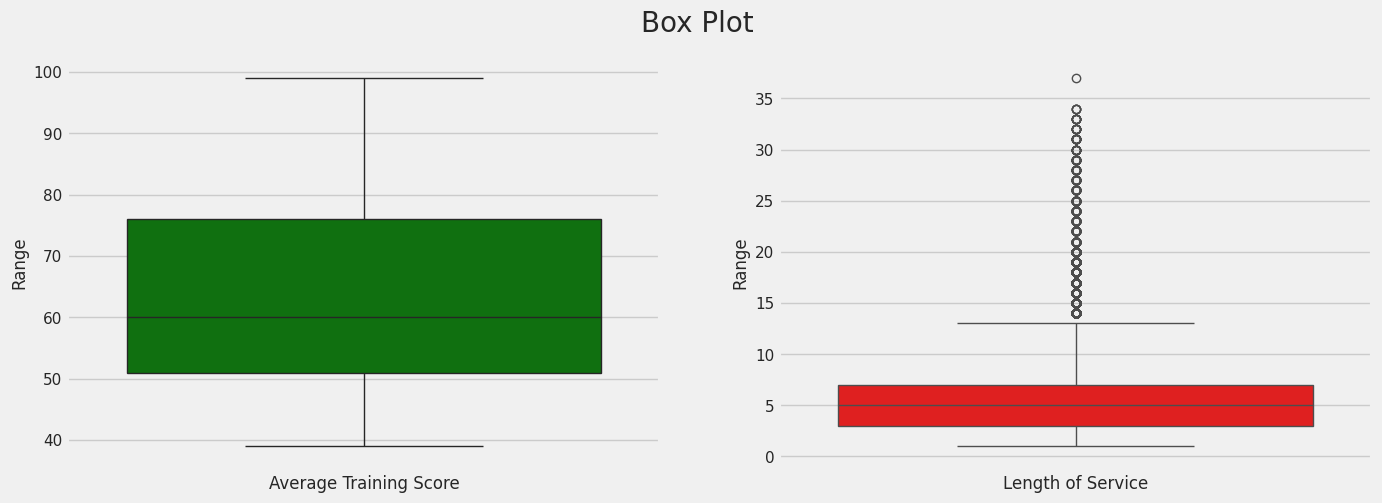

In [205]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
sns.boxplot(df['avg_training_score'], color = 'green')
plt.xlabel('Average Training Score', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

plt.subplot(1, 2, 2)
sns.boxplot(df['length_of_service'], color = 'red')
plt.xlabel('Length of Service', fontsize = 12)
plt.ylabel('Range', fontsize = 12)

plt.suptitle('Box Plot', fontsize = 20)
plt.show()

Много выбросов в Length of Service

In [206]:
# ручная обработка выбросов (конечно, можно через 5 и 95 перцентили, заменой на граничное значение и т.д., но для этой задачи выбрал этот простой вариант :)

df = df[df['length_of_service'] > 13]

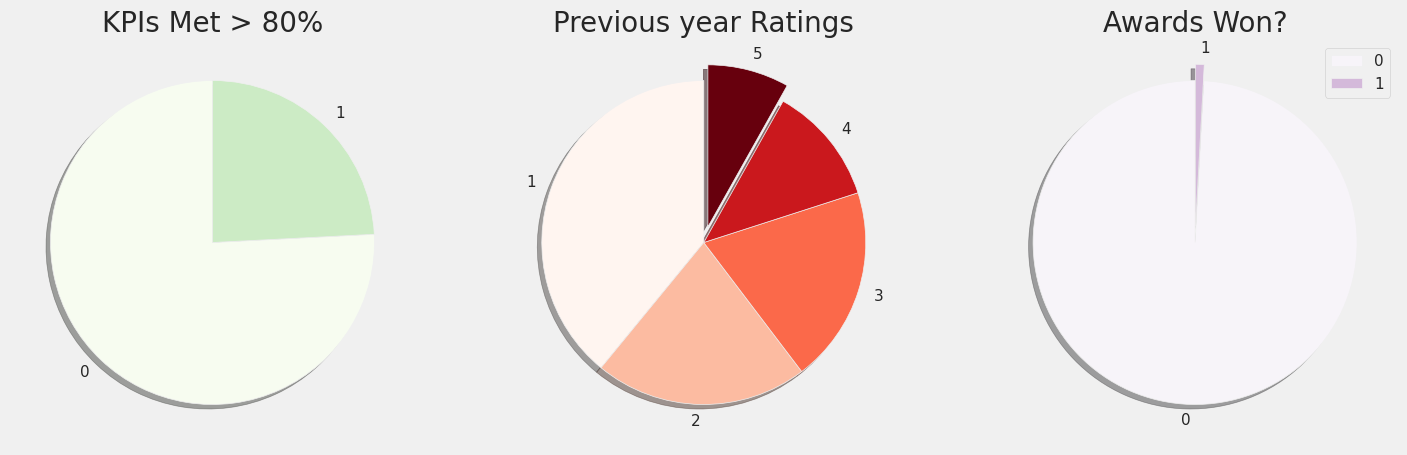

In [207]:
plt.rcParams['figure.figsize'] = (16,5)
plt.style.use('fivethirtyeight')

plt.subplot(1, 3, 1)
labels = ['0','1']
sizes = df['KPIs_met >80%'].value_counts()
colors = plt.cm.GnBu(np.linspace(0, 1, 5))
explode = [0, 0]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('KPIs Met > 80%', fontsize = 20)

plt.subplot(1, 3, 2)
labels = ['1', '2', '3', '4', '5']
sizes = df['previous_year_rating'].value_counts()
colors = plt.cm.Reds(np.linspace(0, 1, 5))
explode = [0, 0, 0, 0, 0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Previous year Ratings', fontsize = 20)

plt.subplot(1, 3, 3)
labels = ['0', '1']
sizes = df['awards_won?'].value_counts()
colors = plt.cm.PuRd(np.linspace(0, 1, 5))
explode = [0,0.1]

plt.pie(sizes, labels = labels, colors = colors, explode = explode, shadow = True, startangle = 90)
plt.title('Awards Won?', fontsize = 20)

plt.legend()
plt.show()

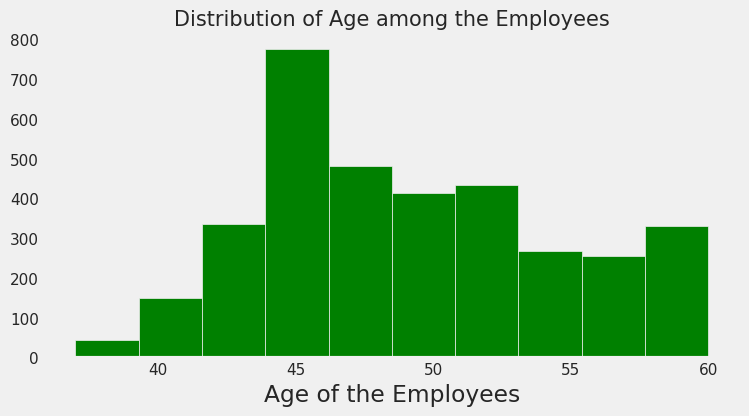

In [208]:
# распределение возраста работников

plt.rcParams['figure.figsize'] = (8, 4)
plt.hist(df['age'], color = 'green')
plt.title('Distribution of Age among the Employees', fontsize = 15)
plt.xlabel('Age of the Employees')
plt.grid()
plt.show()

In [209]:
# Расчет корреляции Пирсона

phik_matrix = df.phik_matrix()

interval columns not set, guessing: ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score', 'is_promoted']


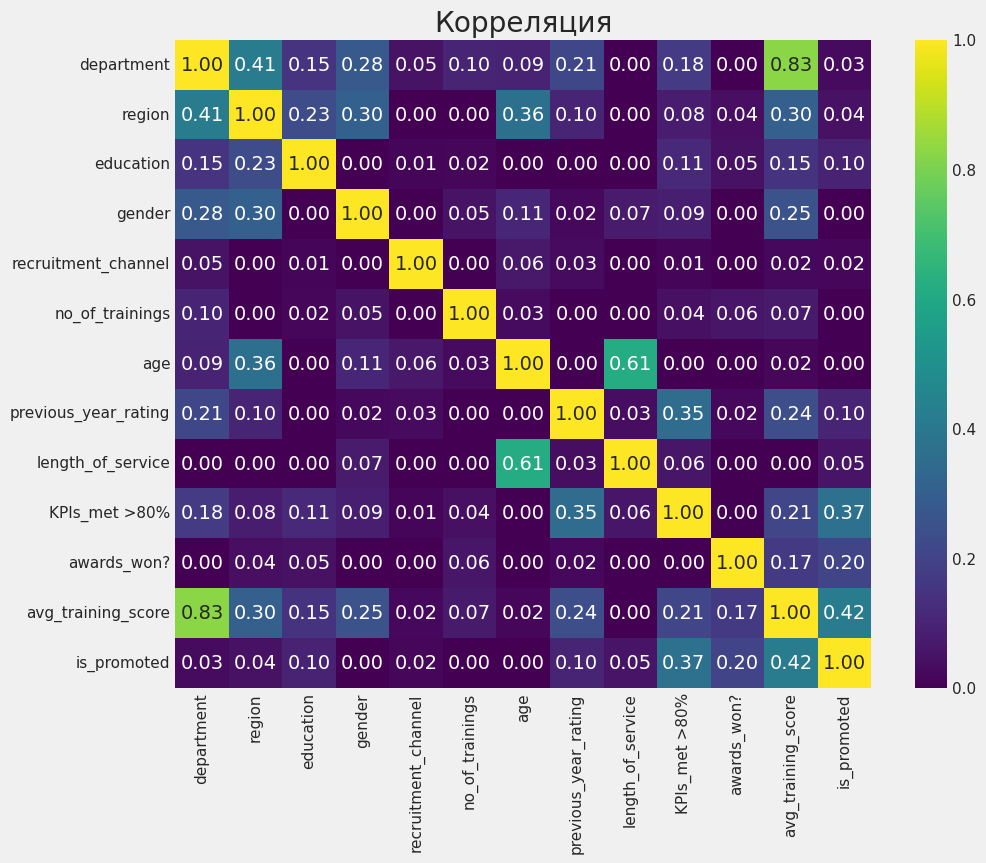

In [210]:
plt.figure(figsize=(10, 8))

sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="viridis")

plt.title("Корреляция")

plt.show()

Высокая корреляция avg_training_score и department. Можно удалить 1 из кор.признаков, но сразу лучше посмотреть на результат после создания модели.

## Feature Engineering

In [211]:
df['sum_metric'] = df['awards_won?']+df['KPIs_met >80%'] + df['previous_year_rating']

df['total_score'] = df['avg_training_score'] * df['no_of_trainings']

In [212]:
df = df.drop(['recruitment_channel', 'region'], axis = 1)

In [213]:
df.duplicated().sum()

36

In [214]:
df = df.drop_duplicates()

In [215]:
df.select_dtypes('object').head()

,department,education,gender
employee_id,,,
38401,Technology,Master's & above,m
23560,HR,Bachelor's,m
17673,Sales & Marketing,Master's & above,m
77577,Sales & Marketing,Bachelor's,m
51256,Finance,Master's & above,m


In [216]:
df['education'].value_counts()

education
Master's & above    1744
Bachelor's          1709
Name: count, dtype: int64

Перекодирование

In [217]:
df['education'] = df['education'].replace(("Master's & above", "Bachelor's", "Below Secondary"),
                                                (3, 2, 1))
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['department'] = le.fit_transform(df['department'])
df['gender'] = le.fit_transform(df['gender'])

In [218]:
df.head(3)

,department,education,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,sum_metric,total_score
employee_id,,,,,,,,,,,,,
38401,8,3,1,2,39,3.000,16,0,0,80,0,3.000,160
23560,2,2,1,1,59,4.000,26,1,0,52,0,5.000,52
17673,7,3,1,1,50,4.000,17,1,0,47,1,5.000,47




---



## Разделение данных


In [219]:
X = df.drop(["is_promoted"], axis=1)
y = df["is_promoted"]

In [220]:
X_training, X_test, y_training, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# для валидации
X_train, X_val, y_train, y_val = train_test_split(
    X_training, y_training, test_size=0.25, random_state=1, stratify=y_training
)

print(X_train.shape, X_val.shape, X_test.shape)

(2071, 12) (691, 12) (691, 12)


**Данные разделены, выделена валидационная выборка + тестовая, а также использована стратификация, так как есть дисбаланс классов.**

In [221]:
df_new =df.copy()

In [222]:
X_train[["education"]] = imputer_mode.fit_transform(X_train[["education"]])

X_val[["education"]] = imputer_mode.transform(X_val[["education"]])

X_test[["education"]] = imputer_mode.transform(X_test[["education"]])

In [223]:
X_train[["previous_year_rating", "avg_training_score"]] = imputer_median.fit_transform(
    X_train[["previous_year_rating", "avg_training_score"]])

X_val[["previous_year_rating", "avg_training_score"]] = imputer_median.transform(
    X_val[["previous_year_rating", "avg_training_score"]])

X_test[["previous_year_rating", "avg_training_score"]] = imputer_median.transform(
    X_test[["previous_year_rating", "avg_training_score"]])

In [224]:
print(X_train.isnull().sum())
print("*" * 40)
print(X_val.isnull().sum())
print("*" * 40)
print(X_test.isnull().sum())

department              0
education               0
gender                  0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
sum_metric              0
total_score             0
dtype: int64
****************************************
department              0
education               0
gender                  0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
sum_metric              0
total_score             0
dtype: int64
****************************************
department              0
education               0
gender                  0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
sum_metr

Данные трансформированы и предобработаны.



---



# Модель

In [225]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_test.shape)

(2071, 12) (691, 12)


In [226]:
def model_performance_classification_sklearn(model, predictors, target):

    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred)
    precision = precision_score(target, pred)
    f1 = f1_score(target, pred, average="macro")


    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [227]:
def confusion_matrix_sklearn(model, predictors, target):

    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [228]:
models = []

models.append(("Logistic regression", LogisticRegression(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []
names = []

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "f1_macro"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = f1_score(y_val, model.predict(X_val), average="macro")
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

Logistic regression: 54.0997074468889
Bagging: 69.97860638034392
Random forest: 61.9461020153373
GBM: 69.36240026579185
Xgboost: 74.80929060609864
dtree: 69.65452797614455

Validation Performance:

Logistic regression: 0.5585416755398441
Bagging: 0.7010775523045463
Random forest: 0.6499493414387031
GBM: 0.6976835221516073
Xgboost: 0.7311564703314639
dtree: 0.6873790951638066


Ожидаемо, что лучший результат у Xgboost (можно было, конечно, вместо него использовать LGBM или яндексовский Catboost).

### Тюнинг лучшей модели

In [229]:
%%time

Model = XGBClassifier(random_state=1,eval_metric='logloss')

param_grid={'n_estimators':np.arange(50,300,50),'scale_pos_weight':[0,1,2,5,10],
            'learning_rate':[0.01,0.1,0.2,0.05], 'gamma':[0,1,3,5],
            'subsample':[0.7,0.8,0.9,1]
           }
from sklearn import metrics

scorer = 'f1_macro'

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'scale_pos_weight': 5, 'n_estimators': 250, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.7618864651629007:
CPU times: user 1.21 s, sys: 75.8 ms, total: 1.28 s
Wall time: 18.4 s


In [230]:
tuned_xgb2 = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=2,
    n_estimators=200,
    learning_rate=0.1,
    gamma=3,
)
tuned_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [231]:
xgb2_train = model_performance_classification_sklearn(tuned_xgb2, X_train, y_train)
xgb2_train

,Accuracy,Recall,Precision,F1
0,0.968,0.593,0.892,0.848


In [232]:
xgb2_val = model_performance_classification_sklearn(tuned_xgb2, X_val, y_val)
xgb2_val

,Accuracy,Recall,Precision,F1
0,0.948,0.340,0.762,0.722


Хорошие значения метрик!



---



### Пробую тюнинг GBM

Добавил Adaboost

In [233]:
%%time

Model = GradientBoostingClassifier(random_state=1)

param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

scorer = 'f1_macro'

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.7205312055520678:
CPU times: user 1.94 s, sys: 214 ms, total: 2.16 s
Wall time: 1min


In [234]:
tuned_gbm2 = GradientBoostingClassifier(
    random_state=1,
    subsample=0.7,
    n_estimators=125,
    max_features=0.7,
    learning_rate=0.2,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm2.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_features=0.7,
                           n_estimators=125, random_state=1, subsample=0.7)

In [235]:
gbm2_train = model_performance_classification_sklearn(tuned_gbm2, X_train, y_train)
gbm2_train

,Accuracy,Recall,Precision,F1
0,0.982,0.736,0.990,0.917


In [236]:
gbm2_val = model_performance_classification_sklearn(tuned_gbm2, X_val, y_val)
gbm2_val

,Accuracy,Recall,Precision,F1
0,0.933,0.319,0.517,0.680


Результаты хуже предыдущей.

In [237]:
%%time

Model = AdaBoostClassifier(random_state=1)

param_grid = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

scorer = 'f1_macro'

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 20, 'learning_rate': 1, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.7296791144422387:
CPU times: user 1.69 s, sys: 206 ms, total: 1.9 s
Wall time: 1min 10s


In [238]:
tuned_adb2 = AdaBoostClassifier(
    random_state=1,
    n_estimators=100,
    learning_rate=1,
    base_estimator=DecisionTreeClassifier(max_depth=2, random_state=1),
)
tuned_adb2.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         random_state=1),
                   learning_rate=1, n_estimators=100, random_state=1)

In [239]:
adb2_train = model_performance_classification_sklearn(tuned_adb2, X_train, y_train)
adb2_train

,Accuracy,Recall,Precision,F1
0,0.988,0.857,0.968,0.951


In [240]:
adb2_val = model_performance_classification_sklearn(tuned_adb2, X_val, y_val)
adb2_val

,Accuracy,Recall,Precision,F1
0,0.931,0.340,0.485,0.682


In [241]:
models_train_comp_df = pd.concat(
    [
        xgb2_train.T,
        gbm2_train.T,
        adb2_train.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost",
    "Gradient Boosting",
    "AdaBoost",
]
print("Сравнение алгоритмов на трейне:")
models_train_comp_df

Сравнение алгоритмов на трейне:


,XGBoost,Gradient Boosting,AdaBoost
Accuracy,0.968,0.982,0.988
Recall,0.593,0.736,0.857
Precision,0.892,0.990,0.968
F1,0.848,0.917,0.951


Лучший результат на тренировочной выборке у Adaboost.

In [242]:
models_train_comp_df = pd.concat(
    [xgb2_val.T, gbm2_val.T, adb2_val.T],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost",
    "Gradient Boosting",
    "AdaBoost",
]
print("VСравнение по результатам валидации:")
models_train_comp_df

VСравнение по результатам валидации:


,XGBoost,Gradient Boosting,AdaBoost
Accuracy,0.948,0.933,0.931
Recall,0.340,0.319,0.340
Precision,0.762,0.517,0.485
F1,0.722,0.680,0.682


На валидации лучший Xgboost.

In [243]:
xgb2_test = model_performance_classification_sklearn(tuned_xgb2, X_test, y_test)
xgb2_test

,Accuracy,Recall,Precision,F1
0,0.949,0.426,0.714,0.753


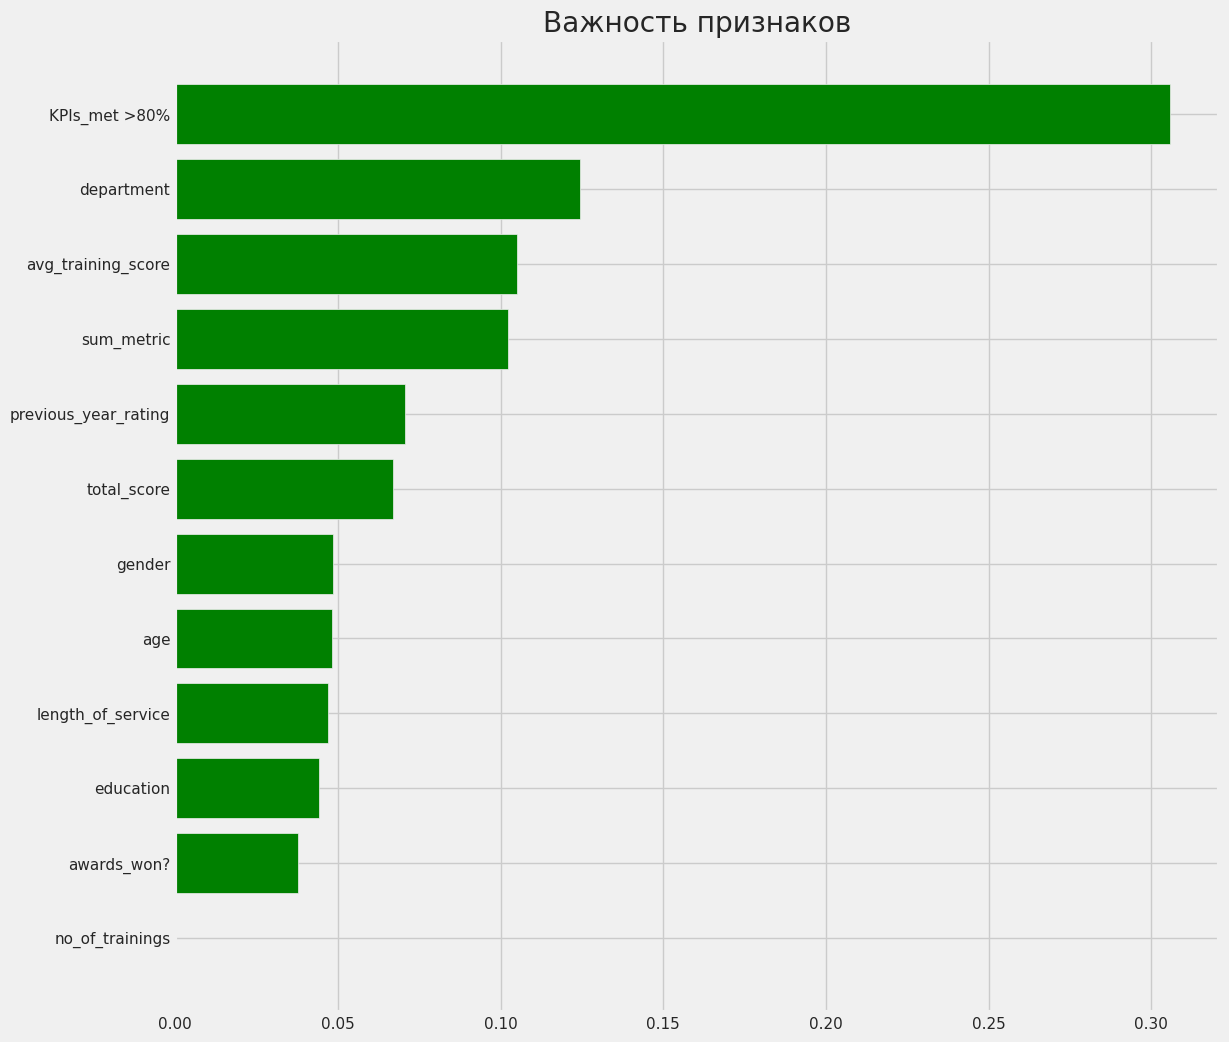

In [244]:
feature_names = X_train.columns
importances = tuned_xgb2.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Важность признаков")
plt.barh(range(len(indices)), importances[indices], color="green", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("")
plt.show()

### Итоговая модель для развертывания

In [245]:
numerical_features = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score']

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

categorical_features = ['department', 'education', 'gender']

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",
)

In [246]:
X = df.drop(columns="is_promoted")
Y = df["is_promoted"]

In [247]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(2417, 12) (1036, 12)


In [248]:
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                eval_metric="logloss",
                subsample=0.9,
                scale_pos_weight=2,
                n_estimators=200,
                learning_rate=0.1,
                gamma=3,
            ),
        ),
    ]
)
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['no_of_trainings', 'age',
                                                   'previous_year_rating',
                                                   'length_of_service',
                                                   'awards_won?',
                                                   'avg_training_score']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignor...
                               feature_types=None, gamma=3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [249]:
y_pred = model.predict_proba(X_test)[:, 1]


In [250]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC на тестовой выборке: {roc_auc:.2f}")


ROC AUC на тестовой выборке: 0.76


Неплохой результат для тестовой выборки.

In [252]:
# Предсказание меток на тестовой выборке
y_pred_labels = model.predict(X_test)

y_pred_labels


array([0, 0, 0, ..., 0, 0, 0])

In [254]:
print("Предсказанные вероятности:")
print(y_pred)

Предсказанные вероятности:
[0.06170963 0.07031105 0.10684548 ... 0.13373306 0.02575276 0.17736994]


In [257]:
# Создание датафрейма с идентификаторами заявок (индексами) и предсказанными вероятностями
predictions_df = pd.DataFrame({
    'application_id': X_test.index,  # Идентификаторы заявок (индексы)
    'predicted_probability': y_pred
})

# Вывод предсказаний
print(predictions_df)

      application_id  predicted_probability
0              69385                  0.062
1              44240                  0.070
2              29167                  0.107
3              58428                  0.039
4              45844                  0.184
...              ...                    ...
1031           53785                  0.045
1032             265                  0.035
1033           67806                  0.134
1034           27859                  0.026
1035           25437                  0.177

[1036 rows x 2 columns]


Модель создана, оценена по метрике ROC AUC, получены предсказания (прогнозы).



---



# Развертывание (deployment)

Так как предстоящий курс все же не про создание моделей, а ML System Design, то актуально и пару ячеек в тетрадке написать о развертывании модели :).

In [258]:
with open("my_best_model_for_babushkin.pkl", "wb") as f:
    pickle.dump(model, f)

Это простейший пример сохранения модели для развертывания.

In [260]:
import streamlit as st

In [261]:
!pip install pyngrok

In [262]:
!ngrok authtoken YOUR TOKEN


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [263]:
%%writefile app.py

# Определение функции предсказания
def make_prediction(department, education, gender, no_of_trainings, age, previous_year_rating, length_of_service, awards_won, avg_training_score):
    with open("my_best_model_for_babushkin.pkl", "rb") as f:
        clf = pickle.load(f)
        input_data = pd.DataFrame([[department, education, gender,no_of_trainings, age, previous_year_rating,
                                    length_of_service, awards_won, avg_training_score]],
                                  columns=['department', 'education', 'gender', 'no_of_trainings', 'age', 'previous_year_rating',
                                           'length_of_service', 'awards_won?', 'avg_training_score'])
        preds = clf.predict(input_data)[0]
    if preds == 1:
        return "Вы имеете право на повышение"
    return "Вы не имеете право на повышение"

def main():

    st.title("Прогнозирование права на повышение")

    department = st.selectbox('Отдел', ['HR', 'Analytics', 'Operations', 'Technology', 'Sales'])
    #region = st.selectbox('Регион', ['Region_1', 'Region_2', 'Region_3'])
    education = st.selectbox('Образование', ["Bachelor's", "Master's", 'Doctorate'])
    gender = st.selectbox('Пол', ['Male', 'Female'])
    #recruitment_channel = st.selectbox('Канал найма', ['Channel_1', 'Channel_2', 'Channel_3'])
    no_of_trainings = st.number_input('Количество тренировок', min_value=0, max_value=10, value=1)
    age = st.number_input('Возраст', min_value=18, max_value=60, value=25)
    previous_year_rating = st.number_input('Рейтинг за предыдущий год', min_value=1.0, max_value=5.0, value=3.0)
    length_of_service = st.number_input('Стаж работы', min_value=0, max_value=40, value=5)
    awards_won = st.number_input('Награды', min_value=0, max_value=10, value=0)
    avg_training_score = st.number_input('Средний балл за тренировки', min_value=0, max_value=100, value=50)

    if st.button('Предсказать'):
        result = make_prediction(department, education, gender, no_of_trainings, age, previous_year_rating, length_of_service, awards_won, avg_training_score)
        st.write(result)

if __name__ == '__main__':
    main()


Overwriting app.py


In [265]:
from pyngrok import ngrok
import subprocess

ngrok.set_auth_token("YOUR TOKEN")

# Запуск ngrok
tunnel = ngrok.connect(8501)
public_url = tunnel.public_url
print(f"Публичный URL: {public_url}")

# Запуск Streamlit
subprocess.Popen(['streamlit', 'run', 'app.py'])

with open("public_url.txt", "w") as f:
    f.write(public_url)



Публичный URL: https://9897-34-127-99-124.ngrok-free.app


для конвертации тетрадки в html

In [266]:
!pip install nbconvert

In [267]:
!jupyter nbconvert --to html --output "/content/task_Bratkovsky_Evgeny.html" "/content/task_Bratkovsky_Evgeny.ipynb"

[NbConvertApp] Converting notebook /content/task_Bratkovsky_Evgeny.ipynb to html
[NbConvertApp] Writing 3484839 bytes to /content/task_Bratkovsky_Evgeny.html


# ВЫВОД:

создано несколько различных моделей бинарной классификации, лучшая из них - модель с использованием XGboost, результат по метрике ROC AUC (площадь под roc-кривой) приемлемый для использования в "проде". Также, хоть этого не требовалось, создан шаблон для развертывания (deployment) модели, так как это задание предполагает отбор не на курс по созданию моделей, а именно на ML System Design!